# Per entry variation analyses: Testing notebook

Here I will test all the plots of the analyses, before compiling them in HTML pages.

## Imports

In [2]:
import os
import pickle 
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np
import logomaker as lm
import nglview as nv
import rdkit
from collections import defaultdict, Counter
from glob import glob
from wordcloud import WordCloud
from IPython.display import Image
from Bio.PDB.DSSP import DSSP
from scipy.spatial.distance import squareform, pdist
from scipy.cluster.hierarchy import dendrogram, cut_tree
from sklearn import manifold

RDKit WARNING: [13:34:56] Enabling RDKit 2019.09.3 jupyter extensions
[13:34:56] Enabling RDKit 2019.09.3 jupyter extensions


## Load pickled test entry and comparisons dataset

In [4]:
with open('/Users/riziotis/ebi/phd/results/csa3d/entries/entries/csa3d_0133.ent', 'rb') as entry:
    entry = pickle.load(entry)
comparisons = pd.read_csv(open('/Users/riziotis/ebi/phd/results/csa3d/variation/data/per_entry/csa3d_0133.csv', 'r'))

## Clustering dendrogram
### Get conserved sane sites

In [6]:
matrix = pd.read_csv('m133_rmsd_matrix.conserved.csv', index_col=0)

In [7]:
sites = [site for site in entry.pdbsites if site.is_sane and (site.is_conserved or site.is_conservative_mutation)]
ids = [p.id for p in entry.get_pdbsites() if p.is_sane and (p.is_conserved or p.is_conservative_mutation)]

### Plot clustered heatmap 

/Users/riziotis/miniconda3/envs/py3/lib/python3.8/site-packages/seaborn/matrix.py:659: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/riziotis/miniconda3/envs/py3/lib/python3.8/site-packages/seaborn/matrix.py:629: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


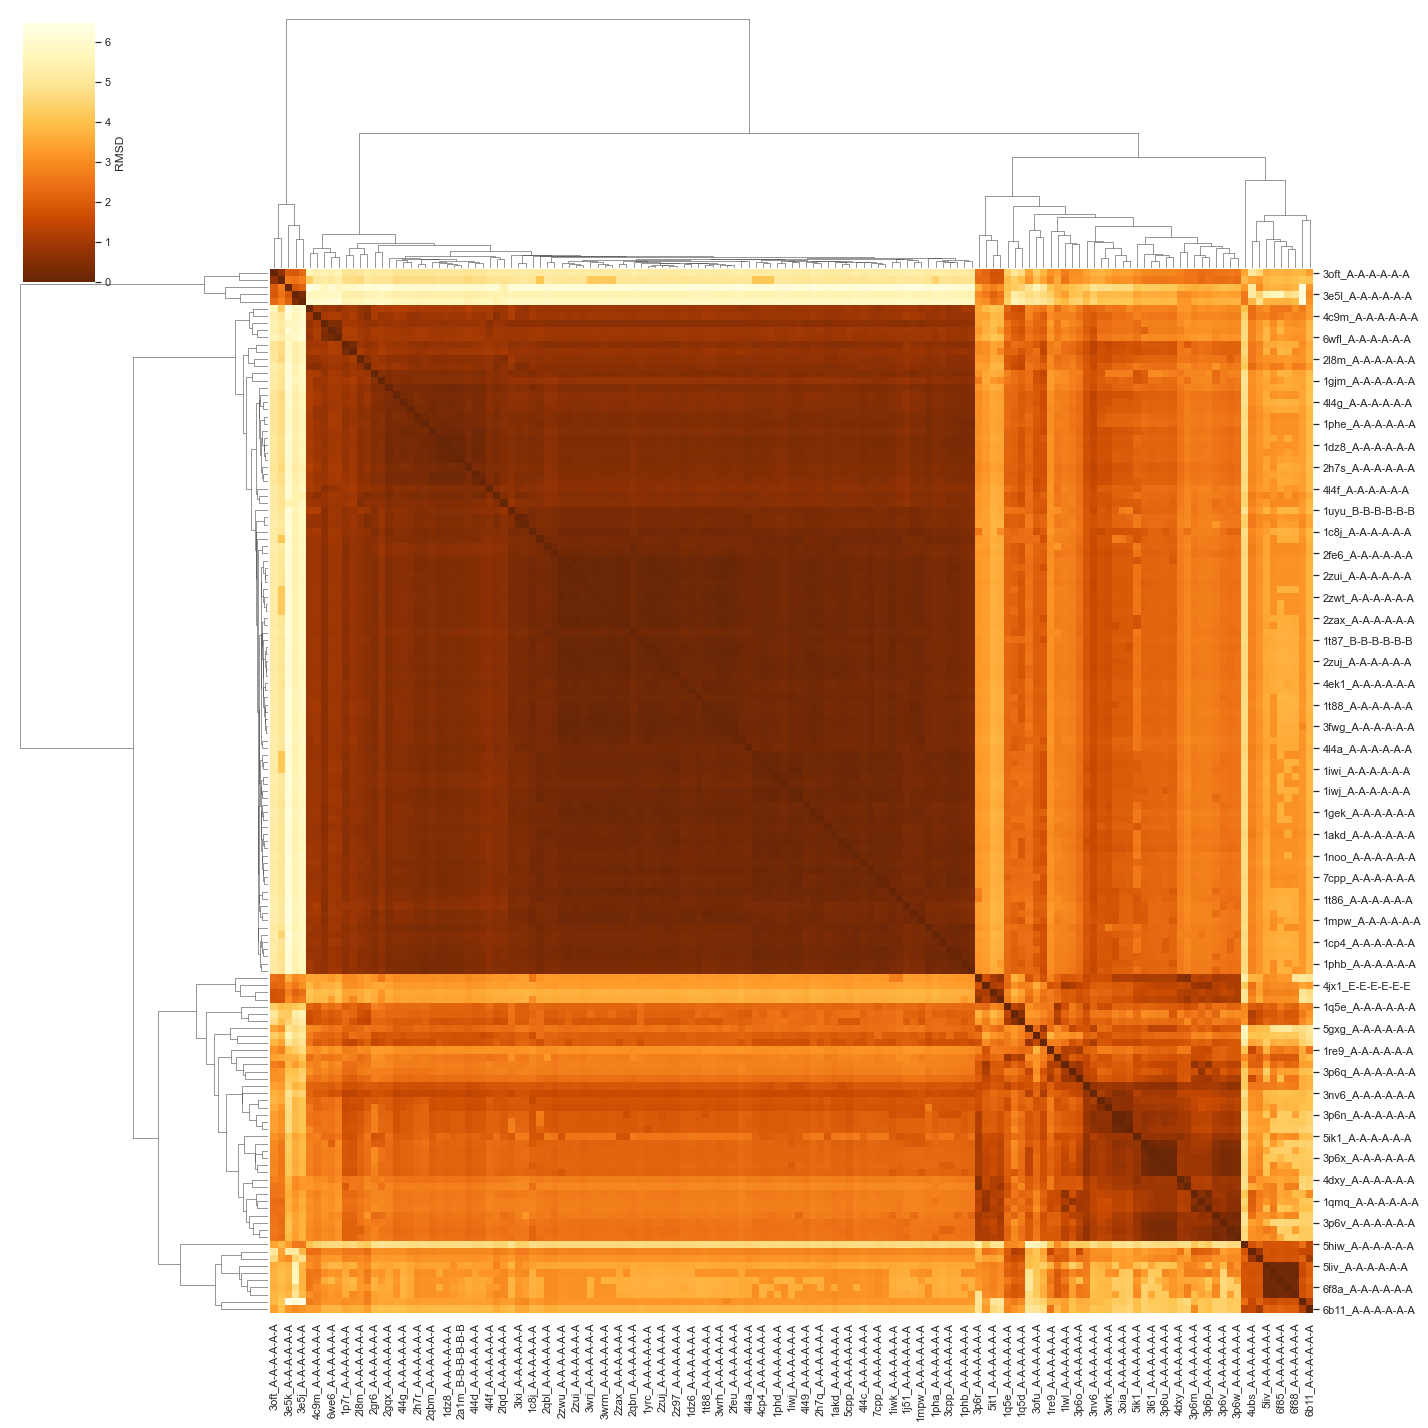

In [8]:
sns.set_theme(style='white')
cmap = sns.color_palette("YlOrBr_r", as_cmap=True)
heatmap = sns.clustermap(matrix, 
                         cmap=cmap,
                         cbar_kws={'label': 'RMSD'}, 
                         figsize=(20,20))

### Derive clusters

In [12]:
Z, clusters = entry.clustering(matrix, height=0.4*max(Z[:,2]))

/Users/riziotis/ebi/csa3d/Entry.py:149: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(matrix, method='average')


In [15]:
# Write coordinates for each cluster
for i in clusters:
    outdir = f'clustered/{i+1}'
    os.makedirs(outdir, exist_ok=True)
    for site in clusters[i]:
        site.reference_site.fit(site, weighted=True, transform=True)
        site.write_pdb(outdir=outdir, func_atoms_only=False, write_hets=False)

In [18]:
# Make template for each cluster
templates = {}
for i, cluster in clusters.items():
    ids = [s.id for s in cluster]
    template, avg = entry.create_template(ca=False, subset=ids)
    templates[i] = template
    print(f'Cluster {i} template: {template.id}')

Cluster 0 template: 1phc_A-A-A-A-A-A
Cluster 1 template: 3e5l_A-A-A-A-A-A
Cluster 2 template: 3p6o_A-A-A-A-A-A
Cluster 3 template: 6f8a_A-A-A-A-A-A


In [24]:
from Bio.PDB.PDBIO import PDBIO
# Get ref
for s in entry.pdbsites:
    if s.is_reference:
        ref = s
        
# Write template and parent coords
for i, template in templates.items():
    ref.fit(template, transform=True, weighted=True)
    template.write_pdb(outfile=f'cluster_{i}.template.{template.pdb_id}.pdb', func_atoms_only=True, write_hets=False)
    # Write parent of template
    io = PDBIO()
    io.set_structure(template.parent_structure)
    io.save(f'{template.pdb_id}.parent.pdb')